# Audio Auto-Tagging
- 일부 소리는 아기의 웃음이나 피아노의 소리와 같이 독특하고 즉시 인식
- 다른 소리는 정확히 찾아 내기 어렵다.
- 눈을 감 으면 전기 톱 소리와 믹서기 소리의 차이를 알수 있을까?
- 우리가 경험하는 방대한 양의 사운드 때문에 신뢰할 수있는 자동 범용 오디오 태깅 시스템은 존재하지 않음.
- 사운드 컬렉션에 주석을 달고 시청각 콘텐츠의 음성이 아닌 이벤트에 캡션을 제공하는 등의 수동 작업이 많이 필요.
- 80개 범주의 다양한 어휘를 사용하여 오디오 데이터에 자동으로 태그를 지정하는 알고리즘을 개발.
- 성공하면 사운드 컬렉션 자동 레이블 지정에서 비디오 컨텐츠에 자동으로 태그를 지정하거나 실시간으로 발생하는 사운드 이벤트를 인식하는 시스템 개발에 이르기까지 다양한 응용 프로그램에 시스템을 사용할 수 있습니다.

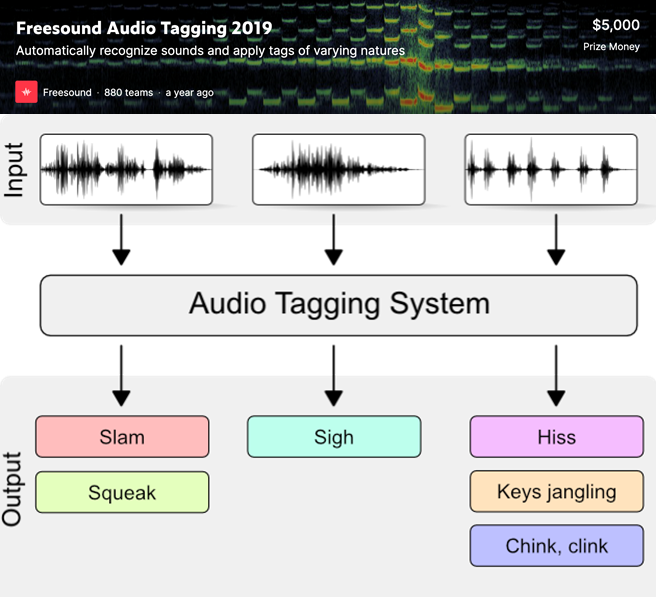

- Auto-Tagging 시스템은 멀티 레이블이면서 멀티 클래스인 분류 문제
- 해당 데이터셋은 80개의 클래스를 갖고 있고 각 클래스는 여러개의 레이블을 갖고 있다. 그러면 OUTPUT은 80개의 노드로 결정되어야 하고, 80개의 노드는 one-hot encoding된 레이블고 loss를 연산을 한다. 그렇다면  OUTPUT layer는 어떤 형태로 나와야 하는가. 


- 보통 Audio Auto Tagging을 평가할 때는 Average Precision, Rank-Average Precision과 같이 IR(Information Retrieval)에서 사용되는 metric이 많이 사용
> Multi-Label Classification을 진행하면, 각 레이블에 대한 점수가 확률벡터로 나오게 될텐데, 실제 1인 Label에 대해서 얼만큼 높은 Rank로 모델이 예측하였는가가 결국 모델이 잘 예측했냐를 평가할 수 있기 때문에 IR쪽에서 사용되는 metric이 자주 사용
- Freesound Audio Auto Tagging 2019에서는 LRAP(Label-Weighted-Label-Ranking-Average-Precision)을 활용해 모델의 성능을 평가
- LRAP는 Label=1인 값에 대해서만 Rank Precision을 계산합니다. y<sub>ij</sub>=1

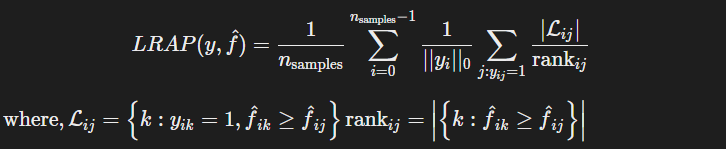

[How to interpret: Label Ranking Average Precision Score](https://stackoverflow.com/questions/55881642/how-to-interpret-label-ranking-average-precision-score)

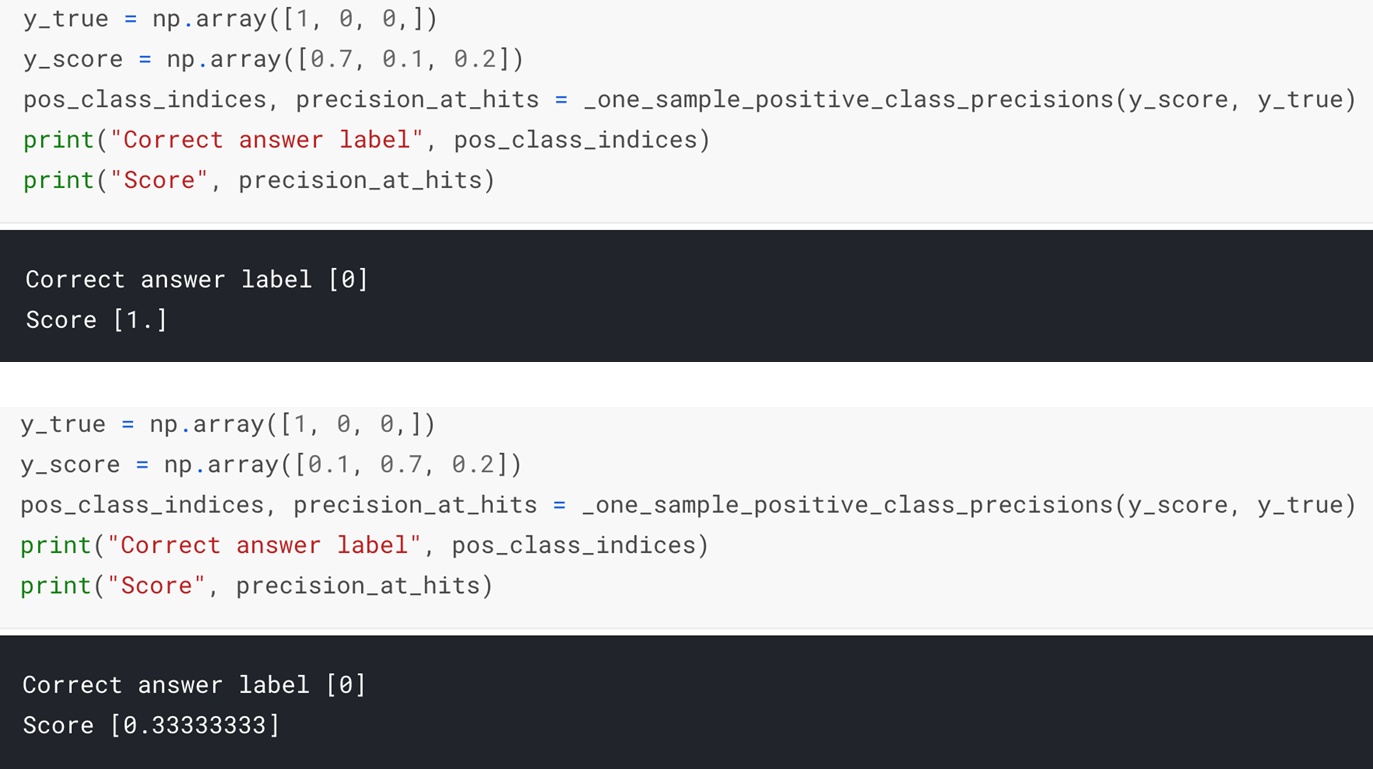

## 해당데이터 label과 히스토그램

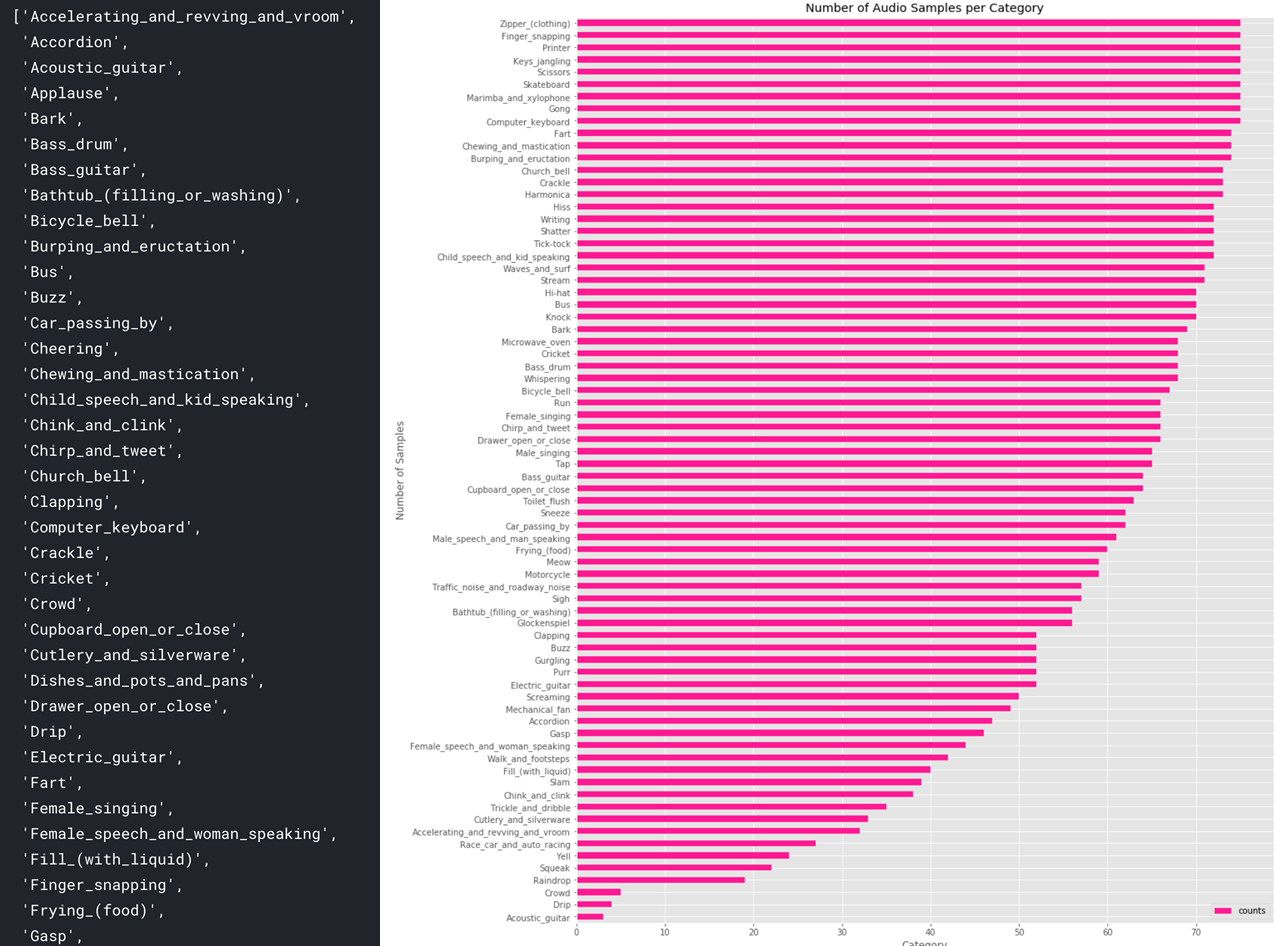

## Auto Tagging Step

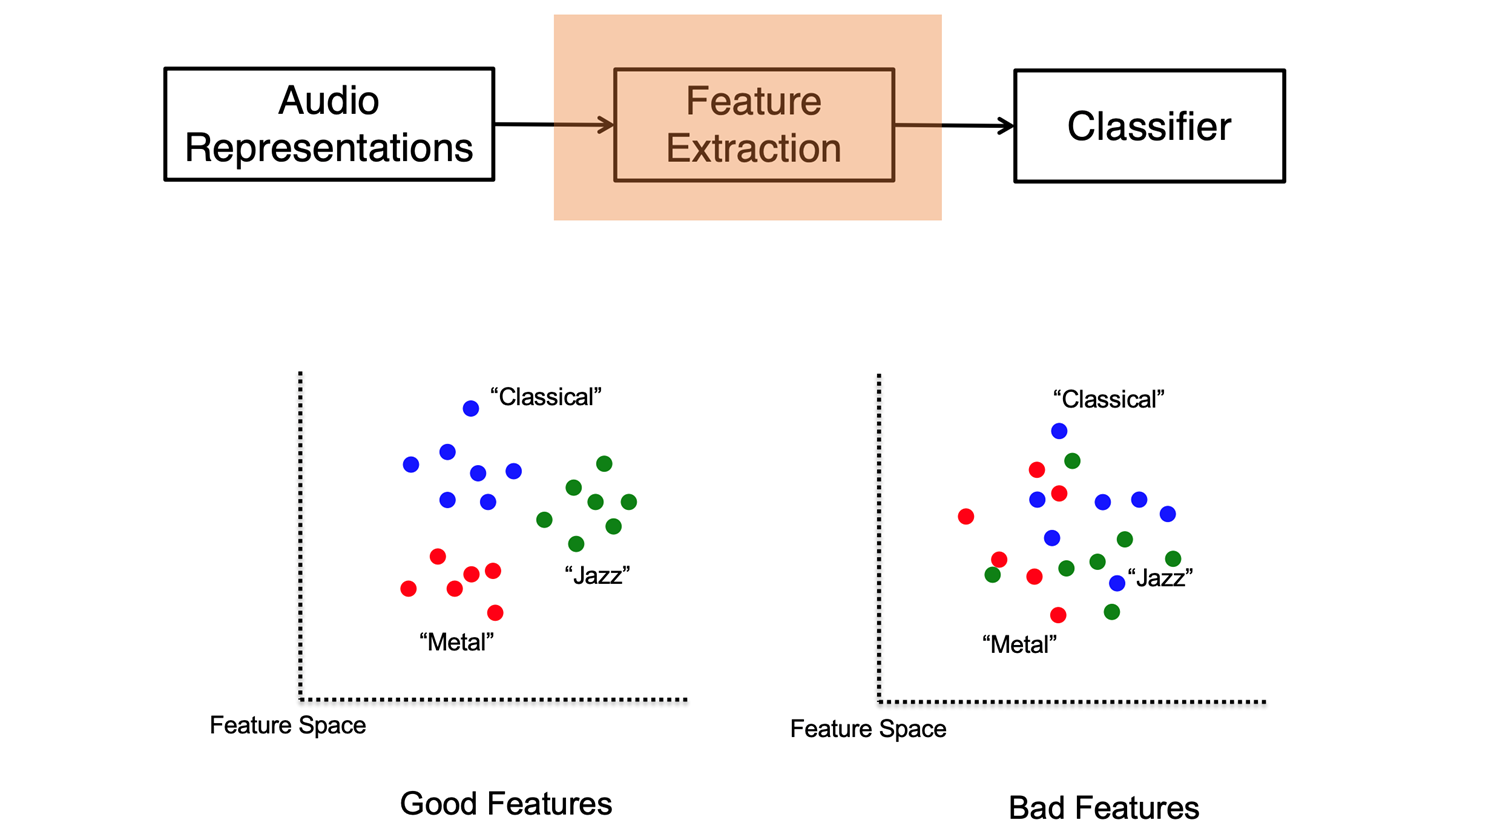

## Deep Learninhg building Blocks
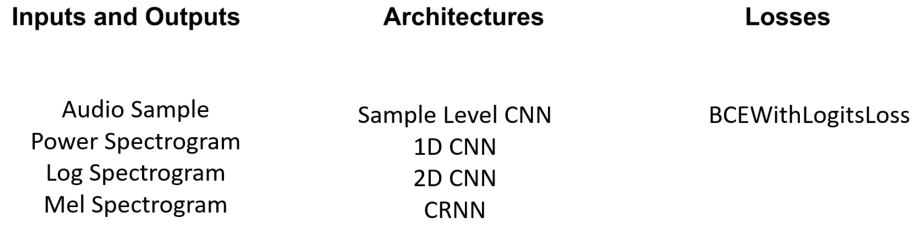

In [ ]:
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -U --no-cache-dir gdown --pre
print("Download Data...")
!mkdir Speech
!gdown --id {"18Zo6CeqzSykDHCACInLU8VhTMOwyqia0"} -O /content/Speech/mels_train_curated.pkl
!gdown --id {"1dqD3NKO85Fw9KouvDVvUdb4GS3EgrPoP"} -O /content/Speech/sample_submission.csv
!gdown --id {"1kJKUqfw9LXdKyD-2Po4qfcXcGT-Ek6gQ"} -O /content/Speech/train_curated.csv

Download Data...
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18Zo6CeqzSykDHCACInLU8VhTMOwyqia0
To: /content/Speech/mels_train_curated.pkl
100% 945M/945M [00:03<00:00, 280MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dqD3NKO85Fw9KouvDVvUdb4GS3EgrPoP
To: /content/Speech/sample_submission.csv
100% 583k/583k [00:00<00:00, 97.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  c

In [ ]:
test_df = pd.read_csv('/content/Speech/sample_submission.csv')
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,426eb1e0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,428d70bb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4292b1c9.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,429c5071.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
labels = test_df.columns[1:].tolist()
num_classes = len(labels)
num_classes

80

In [ ]:
labels

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation',
 'Bus',
 'Buzz',
 'Car_passing_by',
 'Cheering',
 'Chewing_and_mastication',
 'Child_speech_and_kid_speaking',
 'Chink_and_clink',
 'Chirp_and_tweet',
 'Church_bell',
 'Clapping',
 'Computer_keyboard',
 'Crackle',
 'Cricket',
 'Crowd',
 'Cupboard_open_or_close',
 'Cutlery_and_silverware',
 'Dishes_and_pots_and_pans',
 'Drawer_open_or_close',
 'Drip',
 'Electric_guitar',
 'Fart',
 'Female_singing',
 'Female_speech_and_woman_speaking',
 'Fill_(with_liquid)',
 'Finger_snapping',
 'Frying_(food)',
 'Gasp',
 'Glockenspiel',
 'Gong',
 'Gurgling',
 'Harmonica',
 'Hi-hat',
 'Hiss',
 'Keys_jangling',
 'Knock',
 'Male_singing',
 'Male_speech_and_man_speaking',
 'Marimba_and_xylophone',
 'Mechanical_fan',
 'Meow',
 'Microwave_oven',
 'Motorcycle',
 'Printer',
 'Purr',
 'Race_car_and_auto_racing',
 

In [ ]:
train_curated = pd.read_csv('/content/Speech/train_curated.csv')
train_curated.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [ ]:
with open('/content/Speech/mels_train_curated.pkl', 'rb') as curated:
    x_train = pickle.load(curated)

In [ ]:
x_train[0].shape #(frequency dim, time dim, duplicate Value)

(128, 448, 3)

In [ ]:
x_train[3].shape #(frequency dim, time dim, duplicate Value)

(128, 1623, 3)

- 시간단위가 다르다는 문제점이 있다.

In [ ]:
len(x_train), len(train_curated)

(4970, 4970)

In [ ]:
y_train = np.zeros((len(train_curated), num_classes)).astype(int)
for i, row in enumerate(train_curated['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(4970, 80)

In [ ]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    retrieved_classes = np.argsort(scores)[::-1]
    class_rankings = np.zeros(num_classes, dtype=np.int64)
    class_rankings[retrieved_classes] = range(num_classes)
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool_)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float64)))
    return pos_class_indices, precision_at_hits
    """단일 샘플에 대한 각 실제 클래스의 정밀도를 계산합니다.
    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.
    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """

In [ ]:
def calculate_per_class_lwlrap(truth, scores):
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    
    return per_class_lwlrap, weight_per_class
    """label-weighted label-ranking 평균 정밀도를 계산합니다.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """

In [ ]:
_one_sample_positive_class_precisions(np.array([0.7,0.3,0.1]),
                                      np.array([1,0,1]))

(array([0, 2]), array([1.        , 0.66666667]))

In [ ]:
y_true = np.array([[1, 0, 1,], [0, 1, 1]])
y_score = np.array([[0.1, 0.7, 0.2], [0.1, 0.7, 0.2]])
_, precision_at_hits1 = _one_sample_positive_class_precisions(y_score[0], 
                                                              y_true[0])
print("sample 1 Score", precision_at_hits1)
_, precision_at_hits2 = _one_sample_positive_class_precisions(y_score[1], 
                                                              y_true[1])
print("sample 2 Score", precision_at_hits2)
score, weight = calculate_per_class_lwlrap(y_true, y_score)
print("Each class score", score)
print("Weight of each class", weight)
LwLRAP = (score*weight).sum()
print("LwLRAP", LwLRAP)

sample 1 Score [0.66666667 0.5       ]
sample 2 Score [1. 1.]
Each class score [0.66666667 1.         0.75      ]
Weight of each class [0.25 0.25 0.5 ]
LwLRAP 0.7916666666666666


https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=4)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=4)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=0),
            nn.ELU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=0),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        residual = x
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.avg_pool2d(x, 2)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels):
        super().__init__()
        self.mels = mels
        self.labels = labels
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        audio = self.mels[idx]
        audio_clip = audio[:,:128,:]
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        audio_clip = torch.Tensor(audio_clip)
        
        return audio_clip, label

In [ ]:
num_classes = y_train.shape[1]
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, 
                                              test_size=0.2, random_state=0)

In [ ]:
train_dataset = FATTrainDataset(x_trn, y_trn)
valid_dataset = FATTrainDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
y_val[3]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
best_epoch = -1
best_lwlrap = 0.
num_epochs = 80
batch_size = 8
test_batch_size = 64
lr = 3e-3

model = Classifier(num_classes=num_classes).cuda()
criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)

In [ ]:
from fastprogress import master_bar, progress_bar

mb = master_bar(range(num_epochs))
for epoch in mb:
    start_time = time.time()
    model.train()
    avg_loss = 0.

    for x_batch, y_batch in progress_bar(train_loader, parent=mb):
        preds = model(x_batch.cuda())
        loss = criterion(preds, y_batch.cuda())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    model.eval()
    valid_preds = np.zeros((len(x_val), num_classes))
    avg_val_loss = 0.

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        preds = model(x_batch.cuda()).detach()
        loss = criterion(preds, y_batch.cuda())

        preds = torch.sigmoid(preds)
        valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()

        avg_val_loss += loss.item() / len(valid_loader)
        
    score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
    lwlrap = (score * weight).sum()
    
    if (epoch + 1) % 5 == 0:
        elapsed = time.time() - start_time
        mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}\
          val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')

    if lwlrap > best_lwlrap:
        best_epoch = epoch + 1
        best_lwlrap = lwlrap
        torch.save(model.state_dict(), 'weight_best.pt')
        
temp = {
    'best_epoch': best_epoch,
    'best_lwlrap': best_lwlrap,
}